<a href="https://colab.research.google.com/github/matthiasweidlich/conf_tutorial/blob/master/Conformance_Checking_Chapter_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Conformance Checking Chapter 7**
---

### Notebook preliminaries (pip installs, git cloning, imports, ...)

In [ ]:
%config InlineBackend.figure_format = 'svg'
%matplotlib inline
!git clone https://github.com/matthiasweidlich/conf_tutorial.git

In [ ]:
!pip install pmlab-lite

In [1]:
from pmlab_lite.pn import PetriNet, TraceNet, SynchronousProduct
from pmlab_lite.helper.io import pnml 
from pmlab_lite.helper.viz import dot
from pmlab_lite.alignments.a_star import A_Star

## Aligning Event Data and Process Models
---

In [2]:
running_example = PetriNet()
#pnml.load(running_example, '/content/conf_tutorial/running_example.pnml') # path when using the colab button
pnml.load(running_example, './running_example.pnml')                       # path for local execution

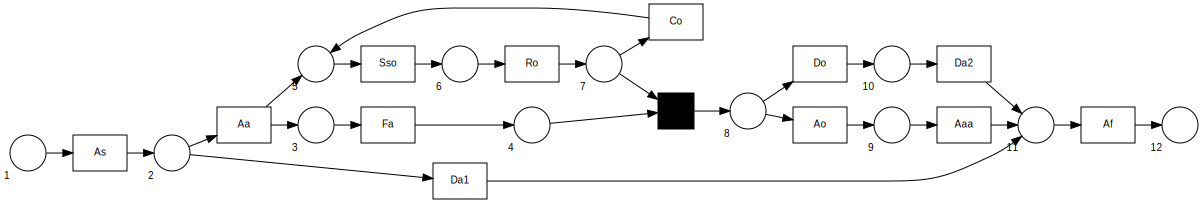

In [3]:
dot.draw_petri_net(running_example)

### Computing Optimal Alignments

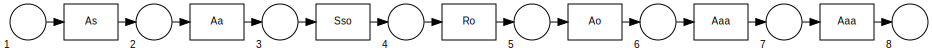

In [4]:
trace = ['As', 'Aa', 'Sso', 'Ro', 'Ao', 'Aaa', 'Aaa']
trace_net = TraceNet(trace)
dot.draw_petri_net(trace_net)

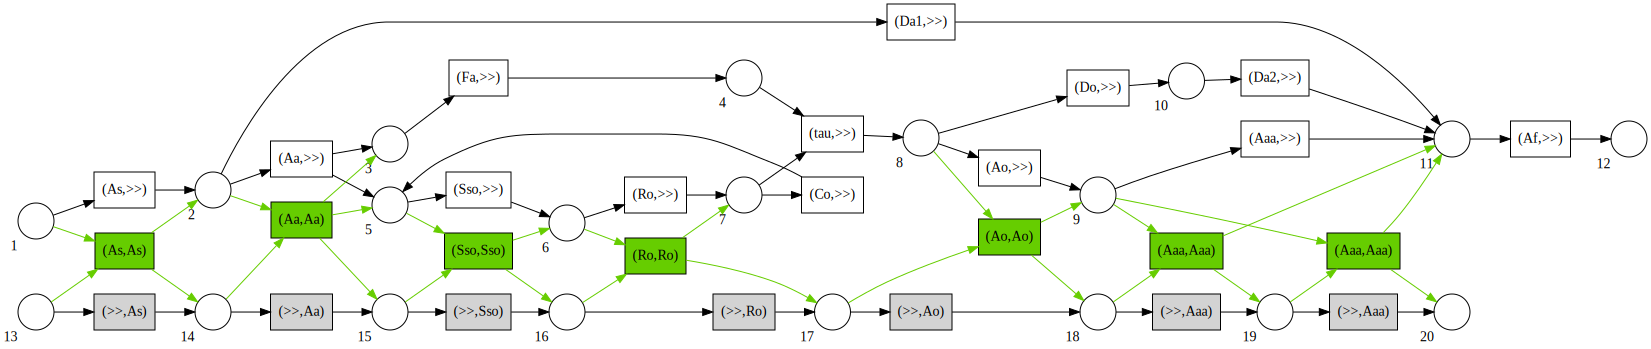

In [5]:
sp = SynchronousProduct(running_example, trace_net)
dot.draw_synchronous_product(sp)

In [7]:
trace_length_searcher1 = A_Star(sp, trace, heuristic='rtl')
trace_length_searcher1.search()

In [8]:
ilp_searcher1 = A_Star(sp, trace, heuristic='ilp')
ilp_searcher1.search()

Compare the alignments found by the trace length and the integer linear programming heuristics

In [9]:
alignment1 = trace_length_searcher1.alignments[0]
alignment2 = ilp_searcher1.alignments[0]

In [10]:
print('Optimal Alignment found using the trace length heuristic:')
trace_length_searcher1.print_alignment(alignment1)
print('Cost of this alignment:', round(alignment1.total_cost, 2))
print()
print('Optimal Alignment found using the ilp heuristic:')
ilp_searcher1.print_alignment(alignment2)
print('Cost of this alignment:', round(alignment2.total_cost, 2))

Optimal Alignment found using the trace length heuristic:
----------------------------------------------------------------------------
| log trace          | As | Aa | Sso | Ro | >> | >>  | Ao | Aaa | Aaa | >> |
----------------------------------------------------------------------------
| execution sequence | As | Aa | Sso | Ro | Fa | tau | Ao | Aaa | >>  | Af |
----------------------------------------------------------------------------
Cost of this alignment: 3.0

Optimal Alignment found using the ilp heuristic:
----------------------------------------------------------------------------
| log trace          | As | Aa | Sso | Ro | >> | >>  | Ao | Aaa | Aaa | >> |
----------------------------------------------------------------------------
| execution sequence | As | Aa | Sso | Ro | Fa | tau | Ao | >>  | Aaa | Af |
----------------------------------------------------------------------------
Cost of this alignment: 3.0


As well the corresponding search spaces spanned while traversing the graph for a solution

In [ ]:
dot.draw_a_star_search_space(trace_length_searcher1)

In [ ]:
dot.draw_a_star_search_space(ilp_searcher1)

*Describe* the differences you observe in the two search spaces shown above. <br>
Furthermore *explain* why these differences occur. <br>
(Additionally *measure* the respective runtimes of the search funtions using python.)

### Another example

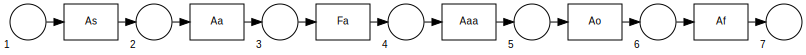

In [15]:
trace2 = ['As', 'Aa', 'Fa', 'Aaa', 'Ao', 'Af']
trace_net2 = TraceNet(trace2)
dot.draw_petri_net(trace_net2)

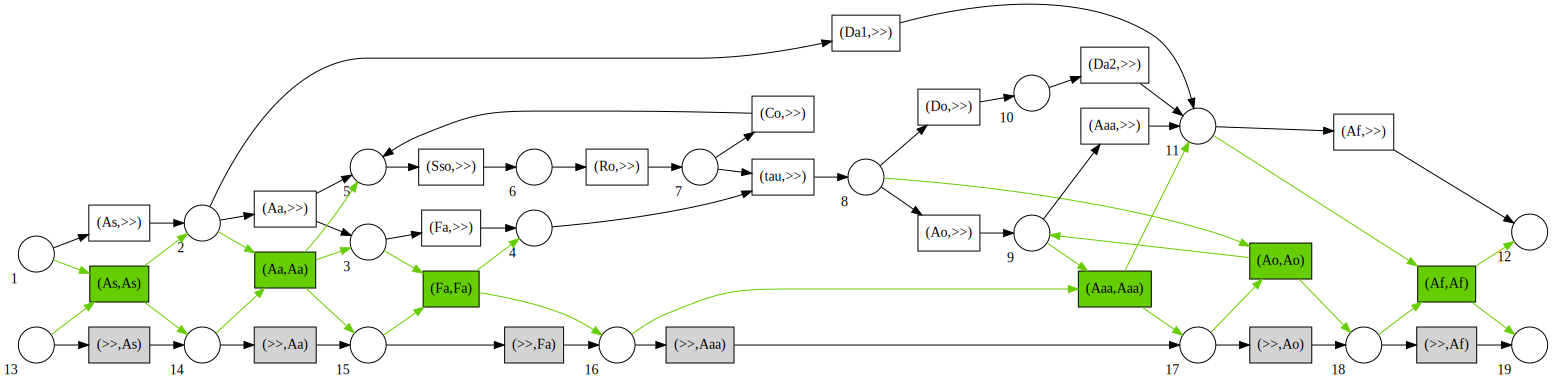

In [16]:
sp = SynchronousProduct(running_example, trace_net2)
dot.draw_synchronous_product(sp)

In [17]:
ilp_searcher2 = A_Star(sp, trace2, heuristic='ilp')
ilp_searcher2.search()

In [18]:
ilp_searcher2.print_alignments()

---------------------------------------------------------------------------
| log trace          | As | Aa | >>  | >> | Fa | >>  | >> | Aaa | Ao | Af |
---------------------------------------------------------------------------
| execution sequence | As | Aa | Sso | Ro | Fa | tau | Ao | Aaa | >> | Af |
---------------------------------------------------------------------------



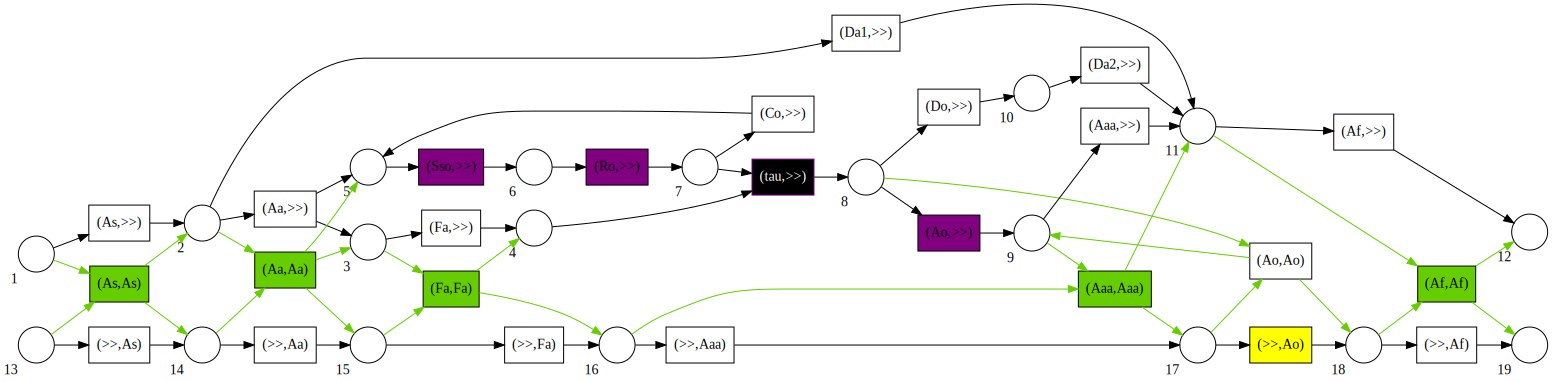

In [24]:
alignment_moves = ilp_searcher2.alignment_moves[0]
dot.draw_alignment_path(sp, alignment_moves)

In [ ]:
dot.draw_a_star_search_space(ilp_heuristic_searcher2)

Changing the cost-function
---


The execution sequence of the synchronous product (from $m_i$ to $m_f$) is a reformulation of finding the optimal alignment(s) between a given process model and trace. This execution sequence ideally should be minimal with respect to some cost function $c$, which associates each transition in the synchronous product a specific cost for being fired. <br> 

__Cost Function__ <br>
Let $ SP = ((P, T, F, \lambda), m_i, m_f)$ be a synchronous product. <br>
A cost function $ c : T \rightarrow \mathbb{R}^+ \cup \{0\}$ is a function associating a non-negative cost to each transition, incurred when firing that transition. <br>

Usually it is desirable to use as many synchronous transitions as possible, i.e. conforming moves, and less model and log moves. This behavior results in the definition of the _default cost function_. <br>

__Default Cost Function__ <br>
The cost function assinging cost $0$ to synchronous moves and $\tau$-labelled transitions and cost $1$ to model and log moves is called the _default cost function_. <br>

Inherently the A*-algorithm assumes the _default cost function_. However the interface allows for arbitrary cost functions to be given to the A* inteface, shown exemplarily below.

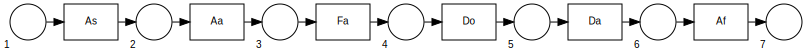

In [25]:
trace = ['As', 'Aa', 'Fa', 'Do', 'Da', 'Af']
trace_net = TraceNet(trace)
dot.draw_petri_net(trace_net)

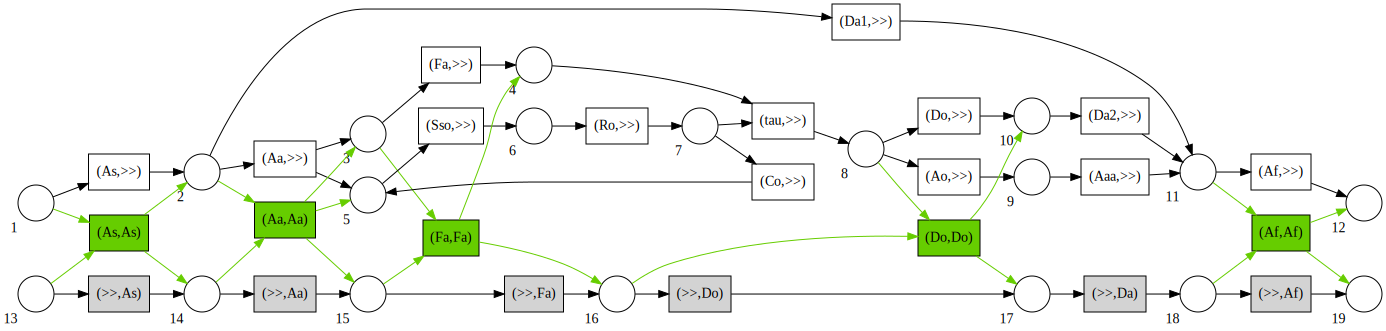

In [26]:
sp = SynchronousProduct(running_example, trace_net)
dot.draw_synchronous_product(sp)

In [27]:
ilp_searcher = A_Star(sp, trace, heuristic='ilp')
ilp_searcher.search()

In [28]:
ilp_searcher.print_alignments()

---------------------------------------------------------------------------
| log trace          | As | Aa | >>  | Fa | >> | >>  | Do | Da | >>  | Af |
---------------------------------------------------------------------------
| execution sequence | As | Aa | Sso | Fa | Ro | tau | Do | >> | Da2 | Af |
---------------------------------------------------------------------------



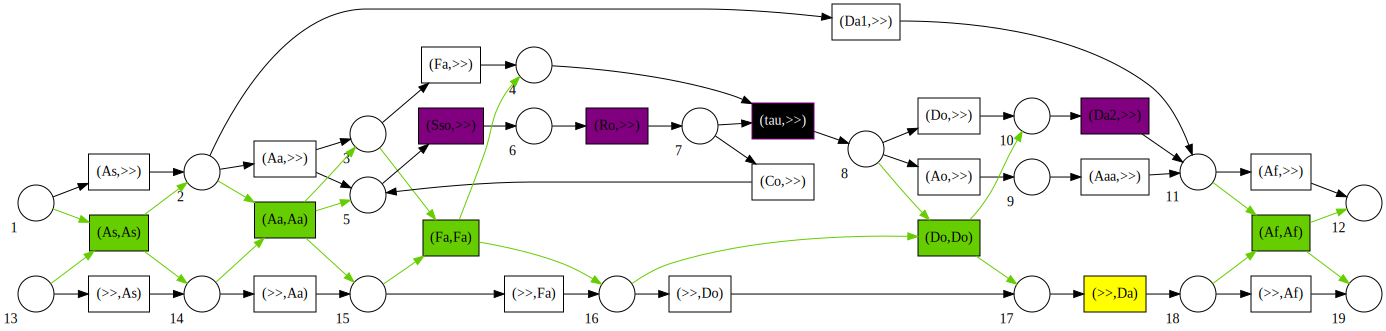

In [29]:
dot.draw_alignment_path(sp, ilp_searcher.alignment_moves[0])

In [36]:
alignment = ilp_searcher.alignments[0]
print('Cost of this alignment:', round(alignment.total_cost, 2))
print('Fitness of this alignment:', round(ilp_searcher.fitness[0], 2))

Cost of this alignment: 4.0
FItness of this alignment: 0.6


In [43]:
# assign cost of 0.2 (instead of 1) for Aa and Fa
# transitions are represtend as tuples as in the pdfs above / the conformance checking book

EPSILON = 0.0001  # very small extra cost to avoid infinite loops
BLANK = '>>'

# implement the function that check for a transition to be of one of the following three types
# assume correct synchronous products, i.e. no try catch of wrong transition namings
def synchronous_move(transition) -> bool:
    return (transition[0] == transition[1]) or ('tau' in transition[0])  # (xx, xx) is a synchronous move

def model_move(transition) -> bool:
    return transition[1] == BLANK  # (xx, >>) is a model move

def log_move(transition) -> bool:
    return transition[0] == BLANK  # (>>, yy) is a log move

def custom_cost(transition: tuple) -> float:
    if transition == ('Aa', '>>') or transition == ('Fa', '>>'):
        return 0.2 + EPSILON  # cheaper cost for Aa and Fa
    #elif transition == ('As', 'As'):
    #    return 7.0 + EPSILON
    elif synchronous_move(transition):
        return EPSILON
    elif model_move(transition) or log_move(transition):
        return 1.0 + EPSILON 

In [44]:
# compute optimal alignments with these updated costs
custom_ilp_searcher = A_Star(sp, trace, heuristic='ilp', cost_func=custom_cost)
custom_ilp_searcher.search()

In [45]:
custom_ilp_searcher.print_alignments()  # result when (As, As) cost is set to 7 and (Aa, >>) + (Fa, >>) are set to 0.2

--------------------------------------------------------------------------------
| log trace          | As | >> | Aa | >>  | >> | Fa | >>  | Do | Da | >>  | Af |
--------------------------------------------------------------------------------
| execution sequence | >> | As | Aa | Sso | Ro | Fa | tau | Do | >> | Da2 | Af |
--------------------------------------------------------------------------------



In [42]:
custom_ilp_searcher.print_alignments()  # result when only (Aa, >>) + (Fa, >>) are set to 0.2

---------------------------------------------------------------------------
| log trace          | As | Aa | >>  | >> | Fa | >>  | Do | Da | >>  | Af |
---------------------------------------------------------------------------
| execution sequence | As | Aa | Sso | Ro | Fa | tau | Do | >> | Da2 | Af |
---------------------------------------------------------------------------

